# Notebook exploration données : event les plus fréquents

## Imports

### Librairies

In [35]:
import os, json, ast
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from babel.dates import format_date
import seaborn as sns

### Data

In [36]:
# nom de fichier et chemin relatif
filename = 'temp_metrics_df.csv'
path = '../data/metrics/'
# création d'un dataframe à partir du csv de données
metrics_df = pd.read_csv(path+filename, index_col=0).sort_values(by='created_at')
metrics_df.head(2)

,id,status,created_at,varnishLevelsTargetvolume,varnishLevelsTotalvolume,events,operators_name,operators_level,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter,events_id
307539,4169748,WARNING,2022-04-15 05:55:06.678,36192.322612,100000,[],Viktor,Operator,1792992,22881,[]
307540,4169749,WARNING,2022-04-15 05:55:06.829,36192.322612,100000,"[{""source"": ""PLC"", ""message"": "" JV-Ti non prêt...",Viktor,Operator,1792992,22881,[391]


In [37]:
metrics_df.columns

Index(['id', 'status', 'created_at', 'varnishLevelsTargetvolume',
       'varnishLevelsTotalvolume', 'events', 'operators_name',
       'operators_level', 'VarnishPrinter_3DVarnishCounter',
       'iFoil_TotalPagesCounter', 'events_id'],
      dtype='object')

## Nettoyage

In [38]:
# indexation du dataset avec les valeurs "created_at"
# metrics_df.index = metrics_df['created_at']
# indexation du dataset avec les valeurs "id"
# metrics_df.set_index('id')
# remise à zero des index
metrics_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
# suppression des colonne contenant des NaN
metrics_df.dropna(axis=1, inplace=True)
# suppression des colonnes non pertinentes
metrics_df.drop(['status','created_at','operators_name','operators_level', 'events_id']  , axis=1, inplace=True)
# metrics_df.drop(['status','operators_name','operators_level']  , axis=1, inplace=True)


metrics_df.head(2)

,id,varnishLevelsTargetvolume,varnishLevelsTotalvolume,events,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
0,4169748,36192.322612,100000,[],1792992,22881
1,4169749,36192.322612,100000,"[{""source"": ""PLC"", ""message"": "" JV-Ti non prêt...",1792992,22881


## Préparation

### Fractionnement de la colonne "events"

In [39]:
# fonction retournant un dataframe des events fractionnés
def create_split_event_dataframe(df, code=None):
    df.events.apply(lambda x :json.loads(x))

    # dicitonnaire de données
    d = {
            'source': [],
            'message': [],
            'timestamp': [],
            'criticality': [],
            'identification': [],
            'id': [],
            'varnishLevelsTargetvolume' : [],
            'varnishLevelsTotalvolume' : [],
            'VarnishPrinter_3DVarnishCounter' : [],
            'iFoil_TotalPagesCounter' : []
            }
    
    # itération dans le dataframe
    for i in range(df.index.start, df.index.stop):
        # evaluation des valeurs 'str' en 'list'
        values_eval = ast.literal_eval(df.events.loc[i])
        # pour chaque list non nulle
        if len(values_eval) > 0 :
            # ajout des valeurs dans le dictionnaire 'd'
            for event in values_eval :
                if code != None :
                    if event.get('identification') == code:
                        d['source'].append(event.get('source'))
                        d['message'].append(event.get('message'))
                        d['timestamp'].append(event.get('timestamp'))
                        d['criticality'].append(event.get('criticality'))
                        d['identification'].append(event.get('identification'))
                        d['id'].append(df.id.loc[i])
                        d['varnishLevelsTargetvolume'].append(df.varnishLevelsTargetvolume.loc[i])
                        d['varnishLevelsTotalvolume'].append(df.varnishLevelsTotalvolume.loc[i])
                        d['VarnishPrinter_3DVarnishCounter'].append(df.VarnishPrinter_3DVarnishCounter.loc[i])
                        d['iFoil_TotalPagesCounter'].append(df.iFoil_TotalPagesCounter.loc[i])
                else :
                    d['source'].append(event.get('source'))
                    d['message'].append(event.get('message'))
                    d['timestamp'].append(event.get('timestamp'))
                    d['criticality'].append(event.get('criticality'))
                    d['identification'].append(event.get('identification'))
                    d['id'].append(df.id.loc[i])
                    d['varnishLevelsTargetvolume'].append(df.varnishLevelsTargetvolume.loc[i])
                    d['varnishLevelsTotalvolume'].append(df.varnishLevelsTotalvolume.loc[i])
                    d['VarnishPrinter_3DVarnishCounter'].append(df.VarnishPrinter_3DVarnishCounter.loc[i])
                    d['iFoil_TotalPagesCounter'].append(df.iFoil_TotalPagesCounter.loc[i])
                    
    # re-assignation de la variable df
    df = pd.DataFrame(data=d)
    # conversion des valeurs 'identification' en entier
    #df['identification'] = pd.to_numeric(df['identification'])
    # conversion des valeurs 'timestamp' au format datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [40]:
df_split = create_split_event_dataframe(metrics_df)

In [41]:
df_split.head(5)

,source,message,timestamp,criticality,identification,id,varnishLevelsTargetvolume,varnishLevelsTotalvolume,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
0,PLC,JV-Ti non prêt : impression impossible,2022-04-15 05:55:23.462000+00:00,INFO,391,4169749,36192.322612,100000,1792992,22881
1,iFoil,JV-Ti non prêt : impression impossible,2022-04-15 06:06:56.278000+00:00,INFO,391,4170152,36192.322612,100000,1792992,22881
2,PLC,En attente,2022-04-15 06:06:56.418000+00:00,INFO,330,4170152,36192.322612,100000,1792992,22881
3,PLC,Disponible,2022-04-15 06:07:28.326000+00:00,INFO,332,4170167,36192.322612,100000,1792992,22881
4,PLC,Chargeur: mode auto non activé,2022-04-15 06:07:37.675000+00:00,WARNING,377,4170172,36192.322612,100000,1792992,22881


### Encodage des identification

In [42]:
# on encode les valeurs du type 'str' avec un code
events_id = []
str_code_dict = {}
str_code = 1000
for id in list(df_split['identification'].unique()) :
    try:
        events_id.append(int(id))
    except ValueError:
        str_code_dict[id] = str_code
        events_id.append(str_code)
        str_code += 1
str_code_dict

{'Kernel_Error': 1000,
 'ICB communication error': 1001,
 'RCB communication error': 1002,
 'iFoil communication error': 1003,
 'Pilot communication error': 1004}

In [43]:
# on remplace dans le dataframe les valeurs du type 'str' avec un code
df_split.identification.replace(str_code_dict, inplace=True)

In [44]:
df_split.head(5)

,source,message,timestamp,criticality,identification,id,varnishLevelsTargetvolume,varnishLevelsTotalvolume,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
0,PLC,JV-Ti non prêt : impression impossible,2022-04-15 05:55:23.462000+00:00,INFO,391,4169749,36192.322612,100000,1792992,22881
1,iFoil,JV-Ti non prêt : impression impossible,2022-04-15 06:06:56.278000+00:00,INFO,391,4170152,36192.322612,100000,1792992,22881
2,PLC,En attente,2022-04-15 06:06:56.418000+00:00,INFO,330,4170152,36192.322612,100000,1792992,22881
3,PLC,Disponible,2022-04-15 06:07:28.326000+00:00,INFO,332,4170167,36192.322612,100000,1792992,22881
4,PLC,Chargeur: mode auto non activé,2022-04-15 06:07:37.675000+00:00,WARNING,377,4170172,36192.322612,100000,1792992,22881


In [45]:
df_split['identification'].unique()

array(['391', '330', '332', '377', '333', '334', '331', 1000, '315',
       '417', '406', '407', '352', '344', 1001, '376', '445', '325',
       '343', '345', '358', '453', '381', '354', '313', '447', '454',
       '387', '386', '372', '371', '323', '480', '311', '479', '351',
       '440', '324', '321', '0', '349', 1002, '385', '357', '418', '446',
       '355', '389', '476', '356', 1003, '460', '472', '405', '380',
       '388', '408', '320', '329', '350', '475', '466', '416', '411',
       '346', '471', '327', '430', '444', '2', '326', '419', 1004, '359',
       '322', '384'], dtype=object)

In [46]:
df_split.set_index('timestamp', inplace=True)


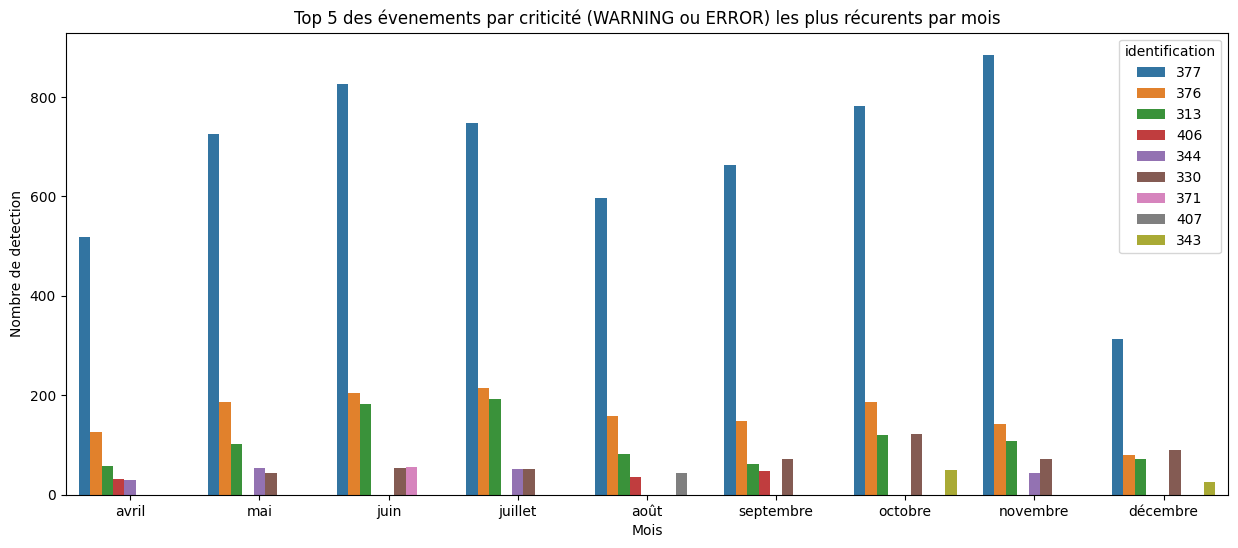

In [52]:
# On filtrer pour n'inclure que les lignes avec 'ERR' ou 'WARNING'.
df_filtered = df_split[df_split['criticality'].isin(['ERR', 'WARNING'])]


# Rééchantillonnage par mois et comptage du nombre d'events_id pour chaque mois.
df_monthly_counts = df_filtered.resample('M')['identification'].value_counts().rename('count').reset_index()

# On groupe par la colonne "created_at" et on applique une fonction lambda à chaque groupe. 
# La fonction lambda prend les 5 premières lignes de chaque groupe sur la base de la colonne "count".
df_top5_monthly = df_monthly_counts.groupby('timestamp').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# On convertie les dates en Français
df_top5_monthly['Month'] = df_top5_monthly['timestamp'].apply(lambda x: format_date(x, 'MMMM', locale='fr_FR'))

# On affiche avec seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x='Month', y='count', hue='identification', data=df_top5_monthly)
plt.title('Top 5 des évenements par criticité (WARNING ou ERROR) les plus récurents par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de detection')
plt.legend(title='identification')

plt.show()